In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.learning_curve import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.externals import joblib
from sklearn import svm
from sklearn import decomposition
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer, explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from time import time
import json
import os
# The usual preamble
%matplotlib inline
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, andigger
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = (15, 5)

D:\Application\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2882: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [22]:
# #############################################################################
# generate training data for all location
month = ['03','04']
isWeekday = False
pickTrainData = 'trainData/pickup_%s.csv'%('weekday' if isWeekday else 'weekend')
flag = True

if not os.path.exists(pickTrainData):
    for i in month:
        taxi = pd.read_csv(r'D:/Application/eclipse/workspace/COMSE6998PROJECT/PreProcessTaxiData/TaxiDataProcessed/cleanData_yellow_tripdata_2016-%s.csv'%i)

        # remove weekends
        taxi['day_of_week'] = pd.to_datetime(taxi['tpep_pickup_datetime']).dt.dayofweek
        if isWeekday:
            taxi = taxi[taxi['day_of_week'] <= 4]
        else:
            taxi = taxi[taxi['day_of_week'] > 4]
        del taxi['day_of_week']

        Time=taxi['tpep_pickup_datetime'].copy().str.slice(8,16)
        taxi['tpep_pickup_datetime']=Time.str.slice_replace(6,8,'51')
        # column name外面最好加中括号
        taxiDate = taxi[['tpep_pickup_datetime']].copy()
        countPickup = taxiDate['tpep_pickup_datetime'].value_counts()
        countPickup = countPickup.sort_index().to_frame()
        countPickup.index.names=['Time']
        countPickup.rename(columns={'tpep_pickup_datetime':'pickup_number'}, inplace = True)
        countPickup.index = countPickup.index.str.slice(3,5)
        # 只需要一个header
        if flag:
            countPickup.to_csv(pickTrainData, mode='a', header=True)
            flag = False
            continue
        countPickup.to_csv(pickTrainData, mode='a', header=False)

In [22]:
taxi.head()

,tpep_pickup_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,duration
0,01 00:51,0.50,-73.977,40.758,-73.978,40.754,4.80,119.0
1,01 00:51,2.20,-73.985,40.757,-73.989,40.733,13.55,727.0
2,01 00:51,0.96,-73.979,40.759,-73.991,40.751,9.80,641.0
3,01 00:51,1.54,-73.985,40.768,-73.991,40.751,11.76,630.0
4,01 00:51,3.50,-73.973,40.757,-73.933,40.766,18.30,903.0


In [23]:
# #############################################################################
# generate training data for weather
month = ['03','04']
isWeekday = False
weatherTrainData = 'trainData/weather_%s.csv'%('weekday' if isWeekday else 'weekend')
flag = True

if not os.path.exists(weatherTrainData):
    for i in month:
        weather = pd.read_csv(r'D:/Application/eclipse/workspace/COMSE6998PROJECT/PreProcessWeatherData/weather_processed_again/weather_2016_%s.csv'%i,index_col='Time')

        # remove weekends
        weather['day_of_week'] = pd.to_datetime(pd.Series(['2016-%s-'%i for x in range(len(weather.index))]).str.cat(weather.index.str.slice(0,2)),format='%Y-%m-%d').dt.dayofweek.values
        if isWeekday:
            weather = weather[weather['day_of_week'] <= 4]
        else:
            weather = weather[weather['day_of_week'] > 4]
        del weather['day_of_week']

        weather.index = weather.index.str.slice(3,5)
        # 只需要一个header
        if flag:
            weather.to_csv(weatherTrainData, mode='a', header=True)
            flag = False
            continue
        weather.to_csv(weatherTrainData, mode='a', header=False)

In [24]:
# #############################################################################
# generate training data for every location
import pandas as pd

index_month_year = {'03': ['2016-03-'+str(i).zfill(2)+' '+str(j).zfill(2)+':51' for i in range(1,32) for j in range(24)],\
               '04': ['2016-04-'+str(i).zfill(2)+' '+str(j).zfill(2)+':51' for i in range(1,31) for j in range(24)]}

index_month = {'03': [str(i).zfill(2)+' '+str(j).zfill(2)+':51' for i in range(1,32) for j in range(24)],\
               '04': [str(i).zfill(2)+' '+str(j).zfill(2)+':51' for i in range(1,31) for j in range(24)]}

month = ['03','04']
isWeekday = False
flag = True

for i in month:

    taxi = pd.read_csv(r'D:/Application/eclipse/workspace/COMSE6998PROJECT/PreProcessTaxiData/TaxiDataProcessed/cleanData_yellow_tripdata_2016-%s.csv'%i)
    Time=taxi['tpep_pickup_datetime'].copy().str.slice(8,16)
    taxi['tpep_pickup_datetime']=Time.str.slice_replace(6,8,'51')
    gb = taxi.groupby(['pickup_longitude', 'pickup_latitude'])
    
    # get filter for weekday or weekend 
    a=index_month_year[i]
    # remove weekends
    data = pd.DataFrame(a,index=a,columns=['tpep_pickup_datetime'])
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['day_of_week'] = data['tpep_pickup_datetime'].dt.dayofweek
    data.index = data.index.str.slice(8,16)
    if isWeekday:
        filt = data['day_of_week'] <= 4
    else:
        filt = data['day_of_week'] > 4
    del data['day_of_week']
    # now filt is the filter of datetime which set weekends as False

    for x in gb:
        if x[0] != (-73.925,40.866): continue
        trainData = 'trainData/'+str(x[0][0])+','+str(x[0][1])+'_%s'%('weekday' if isWeekday else 'weekend')+'.csv'
        temp = pd.DataFrame([0 for j in range(len(index_month[i]))],index=index_month[i],columns=['pickup_number'])
        temp.index.names = ['Time']
        e = x[1].groupby('tpep_pickup_datetime').size().reset_index(name='pickup_number')
        e.index = e['tpep_pickup_datetime']
        del e['tpep_pickup_datetime']
        e.index.names = ['Time']
        select_index = e.index
        temp['pickup_number'].loc[select_index] = e['pickup_number'].loc[select_index]
        temp = temp[filt]
        temp.index = temp.index.str.slice(3,5)
        # 只需要一个header
        if flag:
            temp.to_csv(trainData, mode='a', header=True)
        else:
            temp.to_csv(trainData, mode='a', header=False)
        break
    flag = False

In [29]:
# #############################################################################
def train(filename):

    # #############################################################################
    # load data
    df = pd.read_csv('trainData/'+filename)
    if 'weekday' in filename:
        weather = pd.read_csv('trainData/weather_weekday.csv')
    else:
        weather = pd.read_csv('trainData/weather_weekend.csv')
    df = weather.join(df[['pickup_number']])
    # 重新设置index，因为拼接时index会重复
    df.index = pd.Series(range(0,len(df)))
    df['Time'] = df['Time'].astype('str')
    X = df[['Weather','Time']].copy()
    # series to list: X.tolist()
    test_num = 120 # for the situation where weekends are removed

    # #############################################################################
    # Normalization can spead up the training and bring more accuracy
    y = df['pickup_number'].astype('float')
    y = np.array(y)
    y_min = min(y)
    y_max = max(y)
    y -= y_min
    y /= (y_max-y_min)
    # plot pickup_number of the test data
    plt.plot(list(df.index)[-test_num:], list(df['pickup_number'])[-test_num:])
    plt.scatter(list(df.index)[-test_num:], list(df['pickup_number'])[-test_num:])
    plt.xlabel('time_by_hour')
    plt.ylabel('pickup_number')

    # remove useless columns
    del df['Time']
    del df['Weather']
    del df['pickup_number']

    # #############################################################################
    # Normalization
    df = df.astype('float')
    data = np.array(df)
    x_min = data.min(axis=0)
    x_max = data.max(axis=0)
    data -= x_min
    data /= (x_max-x_min)
    data = pd.DataFrame(data)
    # column names of data: Temp    Wind    Humidity    Barometer   Visibility

    # #############################################################################
    # vectorization
    X = [X.loc[index].to_dict() for index in X.index]
    # all models use the same vectorizer, that is, the vectorizer of training set pickup_weekday.csv
    if os.path.exists('models/' + 'vec.pkl'):
        vec = joblib.load('models/' +  'vec.pkl')
        dummyX = vec.transform(X).toarray()
    else:
        vec = DictVectorizer()    
        dummyX = vec.fit_transform(X).toarray()
        joblib.dump(vec, 'models/' + 'vec.pkl', compress=1)
    # print str(dummyX)
    # print(vec.get_feature_names())
    X = pd.DataFrame(dummyX,columns=vec.get_feature_names())    
    X = data.join(X)
    X = np.array(X)
    
#     def pca(tdm, n_components):
#         pca = decomposition.PCA(n_components=n_components)
#         pca.fit(tdm)
#         reducedTDM = pca.transform(tdm)  # reduced tdm distance matrix

#         with open('pca.pk', 'wb') as fin:
#             pickle.dump(self.pca, fin)
#         return reducedTDM
    
#     X = pca(X,0.99)
    
    # print X.shape # (744L, 58L)
    # print y.shape # (744L,)

    # #############################################################################
    # split train samples and test samples
    # X_train, X_test, y_train, y_test = train_test_split(X, y)
    X_train, X_test, y_train, y_test = X[:-test_num], X[-test_num:], y[:-test_num], y[-test_num:]
    y_test = y_test*y_max+y_min
    # print X_train.shape # (558L, 58L)
    # print y_train.shape # (558L,)

    # #############################################################################
    # grid search

    #grid.best_estimator_返回最佳模型
    # r2_socre用来度量未来的样本是否可能通过模型被很好地预测
    def gridSearchCV(clf, param_grid,score=make_scorer(r2_score)):
        # scoring = {'evc': make_scorer(explained_variance_score), 'r2_score': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}
        grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=score)
        start = time()
        grid_search.fit(X_train, y_train)
        bestScore = round(grid_search.best_score_, 4)
        parameters = grid_search.best_params_
        print("Best Score: " + str(bestScore) + "\nParameters: " + str(parameters))
        return bestScore, parameters, grid_search.best_estimator_

    # #############################################################################
    # Fit regression model

    # SVR RBF kernel
    svr_rbf = svm.SVR(kernel='rbf')
    param_grid = {"C": [1, 10, 100, 1000], "gamma": np.logspace(-2, 2, 5)}
    svr_rbf_score, parameters, svr_rbf = gridSearchCV(svr_rbf, param_grid)

    # SVR Linear kernel
    svr_lin = svm.SVR(kernel='linear')
    param_grid = {"C": [1, 10, 100, 1000]}
    svr_lin_score, parameters, svr_lin = gridSearchCV(svr_lin, param_grid)

    # SVR Polynomial kernel
    svr_poly = svm.SVR(kernel='poly')
    param_grid = {"C": [1, 10, 100, 1000], "degree": [1, 2, 3]}
    svr_poly_score, parameters, svr_poly = gridSearchCV(svr_poly, param_grid)

    # Gradient Boosting regression
    gbr = GradientBoostingRegressor()
    param_grid = {'n_estimators': [500, 700, 900], 'max_depth': [1, 2], 'min_samples_split': [2], 
              'learning_rate': [0.01, 0.1], 'loss': ['lad']}
    gbr_score, parameters, gbr = gridSearchCV(gbr, param_grid)

    # Kernel Ridge Regression
    krr = KernelRidge(kernel='rbf')
    param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)}
    krr_score, parameters, krr = gridSearchCV(krr, param_grid)
    
    # DecisionTreeRegressor
    dtr = DecisionTreeRegressor()
    param_grid = {'max_depth': [2, 4, 6, 8]}
    dtr_score, parameters, dtr = gridSearchCV(dtr, param_grid)
    
    # KNeighborsRegressor
    knr = KNeighborsRegressor()
    param_grid = {'n_neighbors': [2, 4, 6, 8]}
    knr_score, parameters, knr = gridSearchCV(knr, param_grid)
    
    # RandomForestRegressor
    rfr = RandomForestRegressor()
    param_grid = {'max_depth': [2, 4, 6, 8], 'n_estimators': [20, 50, 150, 500]}
    rfr_score, parameters, rfr = gridSearchCV(rfr, param_grid)
    
    # AdaBoostRegressor
    adr = AdaBoostRegressor()
    param_grid = {'n_estimators': [20, 50, 150, 500]}
    adr_score, parameters, adr = gridSearchCV(adr, param_grid)
    
    # BaggingRegressor
    br = BaggingRegressor()
    param_grid = {'n_estimators': [20, 50, 150, 500]}
    br_score, parameters, br = gridSearchCV(br, param_grid)

    # #############################################################################
    # select model with minimized mse and save model
    models = [(svr_rbf,'SVR rbf kernel'),(svr_lin,'SVR linear kernel'),(svr_poly,'SVR polynomial kernel'),\
              (gbr,'Gradient Boosting regression'),(krr,'kernel ridge regression'),\
             (dtr,'DecisionTreeRegressor'),(knr,'KNeighborsRegressor'), (rfr,'RandomForestRegressor'),\
             (adr,'AdaBoostRegressor'),(br,'BaggingRegressor')]
    scores = [svr_rbf_score, svr_lin_score, svr_poly_score, gbr_score, krr_score, dtr_score,\
              knr_score, rfr_score, adr_score, br_score]
    
    index = max(enumerate(scores),key=lambda x: x[1])[0]
    bestModel = models[index][0]
    bestModelName = models[index][1]
    print 'bestModel: ' + bestModelName

    # #############################################################################
    # Visualize learning curves
    def plot_learning_curve(model, modelName):
        train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_train, y=y_train, \
                                                                train_sizes=np.linspace(0.1, 1.0, 10), cv=5, n_jobs=4)
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        # plot in a new graph
        plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training score')
        plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
        plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation score')
        plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
        plt.grid(True)
        plt.xlabel('Number of training samples')
        plt.ylabel('Score')
        plt.title('Learning Curves (%s)'%modelName)
        plt.legend(loc='best')

    # #############################################################################
    # plor the result
    def plot_result(y_pred, modelName):
        x = range(0, len(y_test))
        plt.scatter(x, y_test, color='darkorange', label='Ground truth')
        plt.scatter(x, y_pred, color='navy')
        plt.plot(x, y_pred, color='navy', label='Predict value')
        plt.title(modelName)
        plt.xlabel('time_by_hour')
        plt.ylabel('pickup_number')
        plt.legend()
        plt.savefig("learning_curves_and_prediction_image/%s_%s.png"%(filename[:-4],modelName), dpi=500) 
                            
    # #############################################################################
    # Predict on test samples
    plt.figure()
    plt.subplot(1, 2, 1)
    plot_learning_curve(bestModel, bestModelName)

    # fit the model on train samples
    bestModel.fit(X_train, y_train)

    # save the best model
    joblib.dump(bestModel, 'models/' + filename[:-4] + '.pkl', compress=1)
    dic = {'y_max':y_max, 'y_min':y_min, 'x_max':list(x_max), 'x_min':list(x_min)}
    with open('models/' + filename[:-4] + '_coefficient.js','w') as f:
        json.dump(dic, f)

    plt.subplot(1, 2, 2)
    plot_result(bestModel.predict(X_test)*y_max+y_min, bestModelName)
    plt.show()

    for each in models:
        plt.figure()
        plt.subplot(1, 2, 1)
        plot_learning_curve(each[0], each[1])
        each[0].fit(X_train, y_train)
        plt.subplot(1, 2, 2)
        plot_result(each[0].predict(X_test)*y_max+y_min, each[1])
        plt.show() 
        
#     # scale the result and plot
#     yy = y_pred
#     yyy = (1 - (max(yy)-yy)/(max(yy)-min(yy)))*24000

#     plt.scatter(x, y_test, color='darkorange', label='data')
#     plt.scatter(x, yyy, color='navy')
#     plt.plot(x, yyy, color='navy', label=modelName)
#     # 对应点相连
#     # plt.plot([a.index, a.index], [y_test, yyy*25000], color='blue', linewidth=2.5, linestyle="--")
#     plt.xlabel('data')
#     plt.ylabel('target')
#     plt.legend()
#     plt.show()

Best Score: 0.9175
Parameters: {'C': 100, 'gamma': 0.01}
Best Score: 0.9177
Parameters: {'C': 1000}
Best Score: 0.9177
Parameters: {'C': 1000, 'degree': 1}
Best Score: 0.9323
Parameters: {'min_samples_split': 2, 'loss': 'lad', 'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 1}
Best Score: 0.9329
Parameters: {'alpha': 0.01, 'gamma': 0.01}
Best Score: 0.8534
Parameters: {'max_depth': 8}
Best Score: 0.88
Parameters: {'n_neighbors': 4}
Best Score: 0.8664
Parameters: {'n_estimators': 50, 'max_depth': 8}
Best Score: 0.5353
Parameters: {'n_estimators': 500}
Best Score: 0.9316
Parameters: {'n_estimators': 500}
bestModel: kernel ridge regression


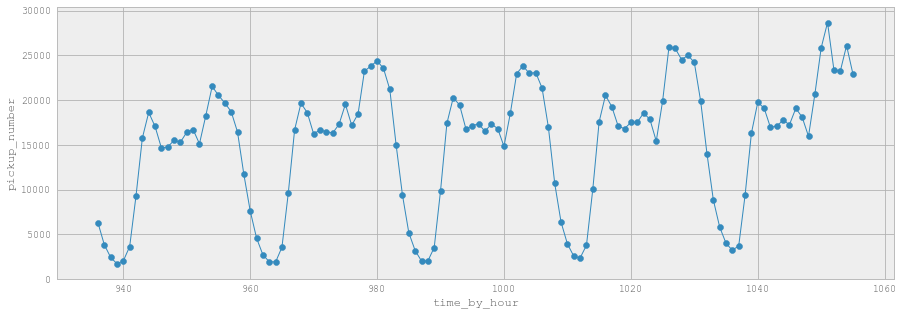

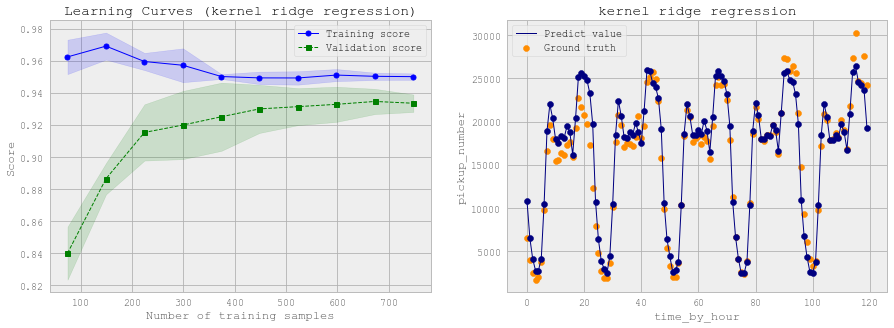

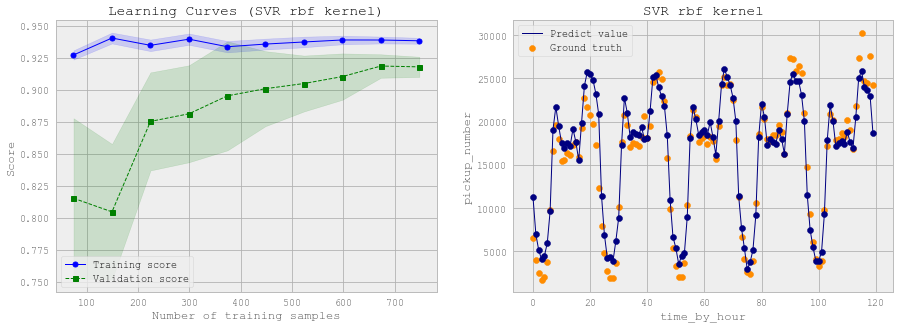

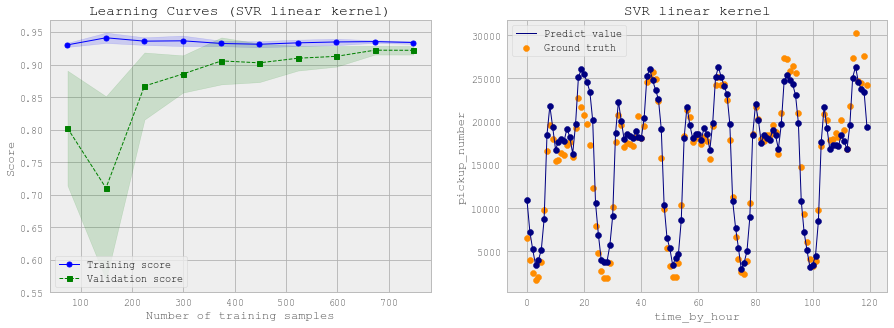

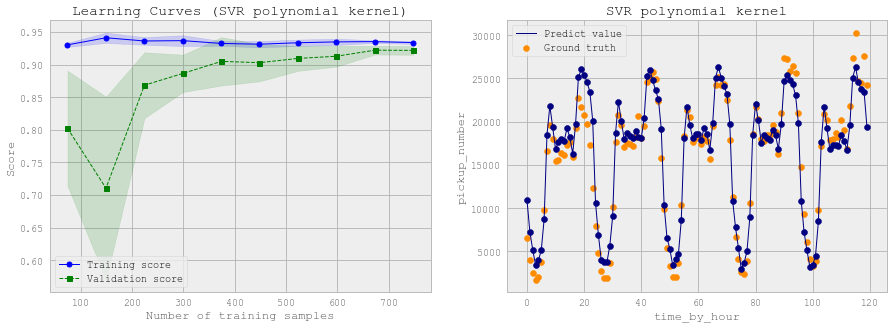

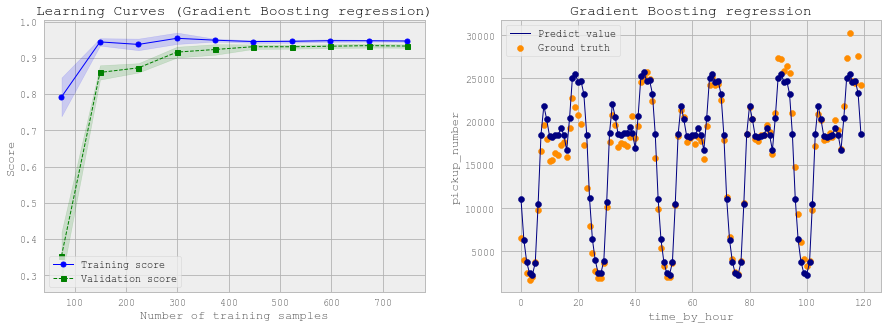

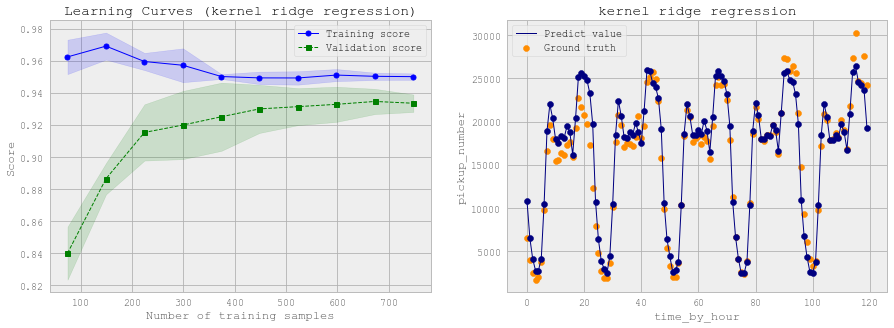

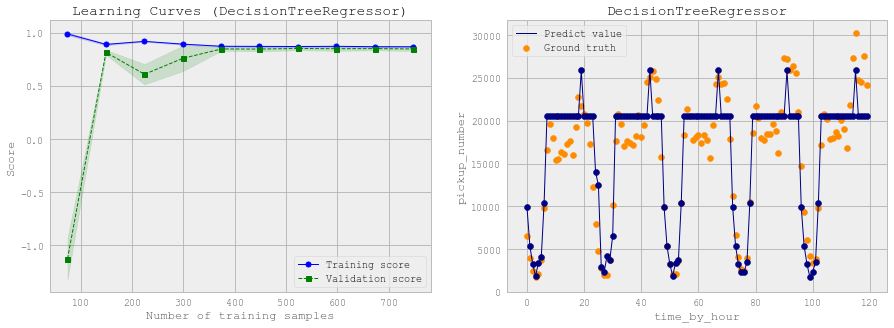

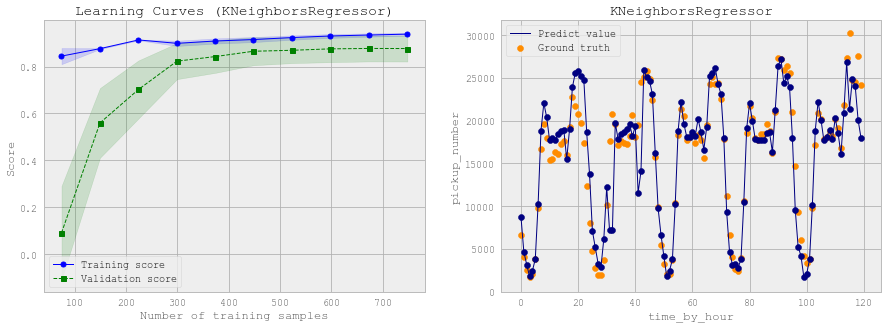

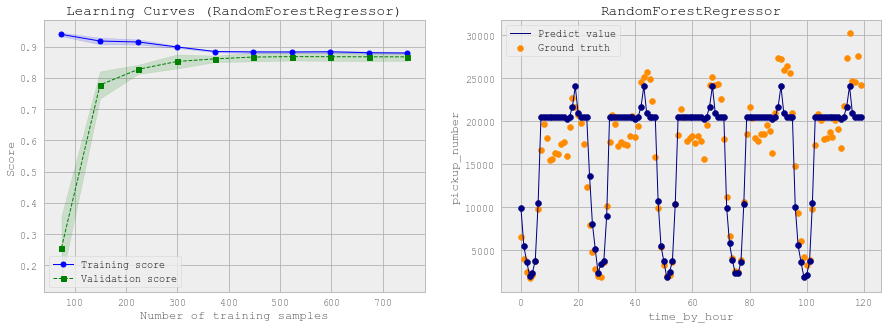

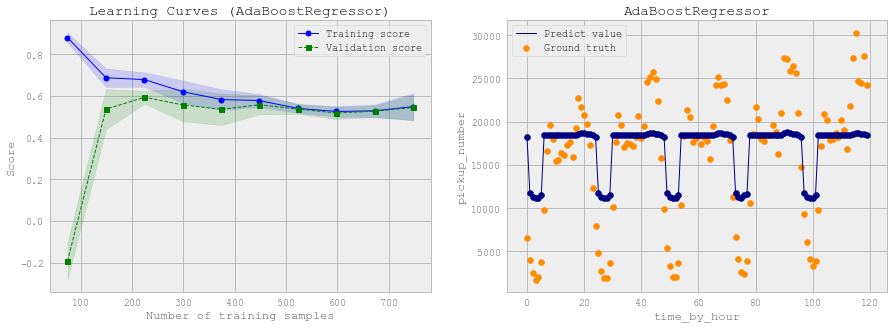

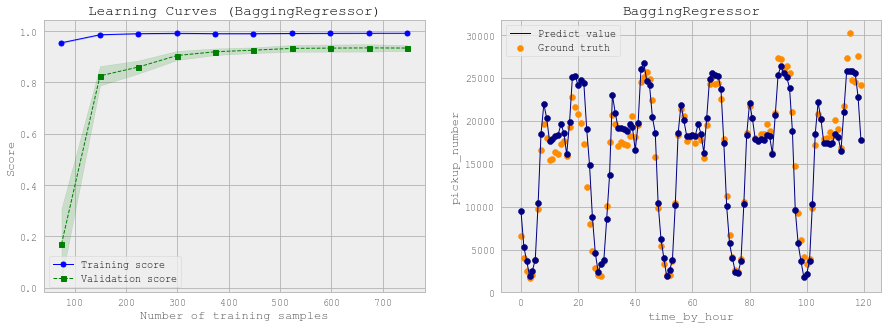

In [49]:
train('pickup_weekday.csv')

Best Score: 0.8214
Parameters: {'C': 10, 'gamma': 0.01}
Best Score: 0.8224
Parameters: {'C': 1}
Best Score: 0.8222
Parameters: {'C': 1000, 'degree': 1}
Best Score: 0.8294
Parameters: {'min_samples_split': 2, 'loss': 'lad', 'learning_rate': 0.1, 'n_estimators': 700, 'max_depth': 1}
Best Score: 0.8362
Parameters: {'alpha': 0.01, 'gamma': 0.01}
Best Score: 0.716
Parameters: {'max_depth': 8}
Best Score: 0.7657
Parameters: {'n_neighbors': 6}
Best Score: 0.7455
Parameters: {'n_estimators': 20, 'max_depth': 8}
Best Score: 0.3583
Parameters: {'n_estimators': 500}
Best Score: 0.8273
Parameters: {'n_estimators': 150}
bestModel: kernel ridge regression


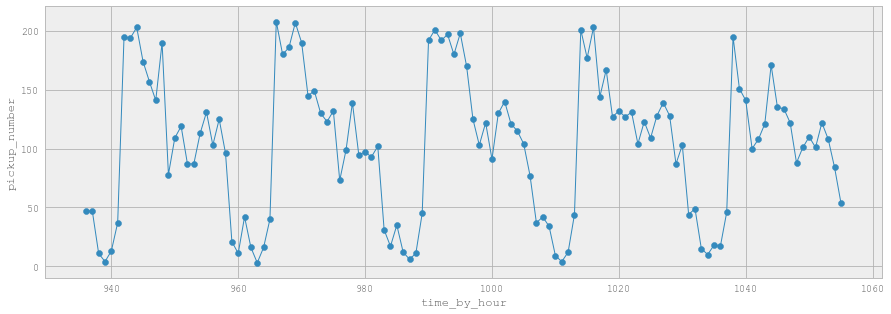

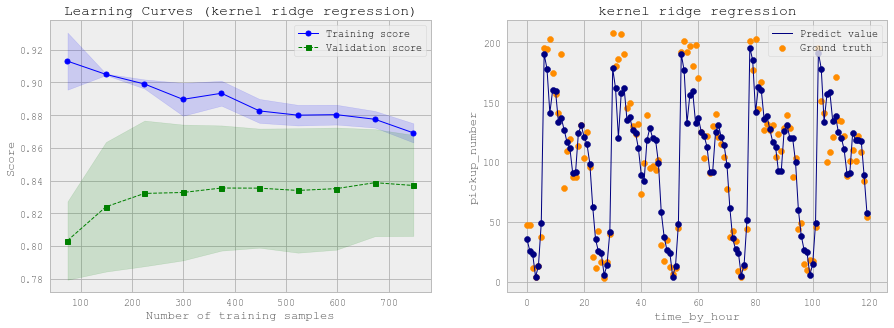

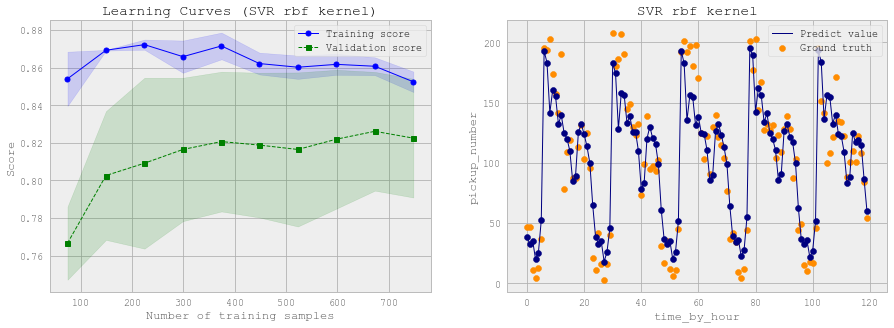

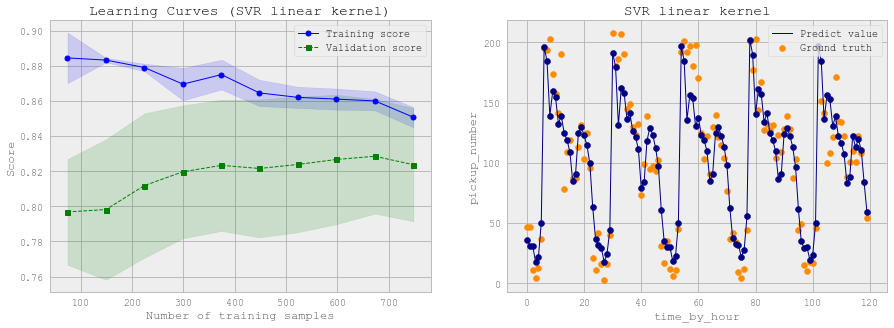

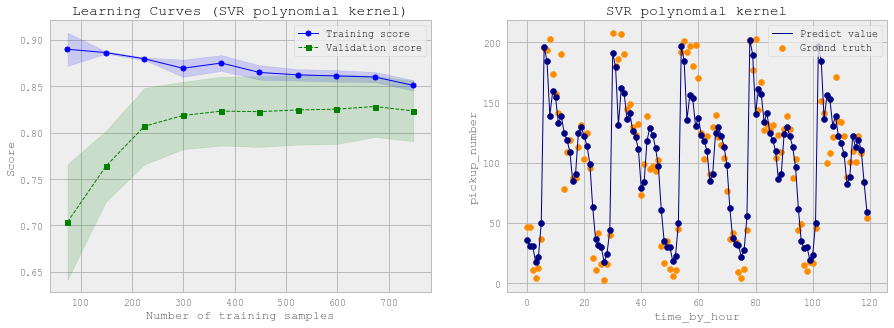

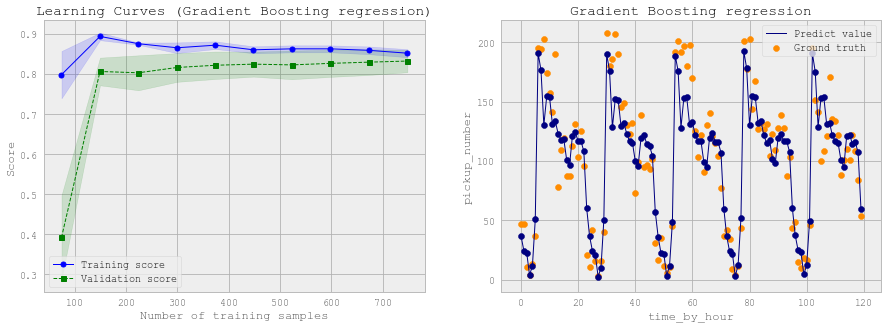

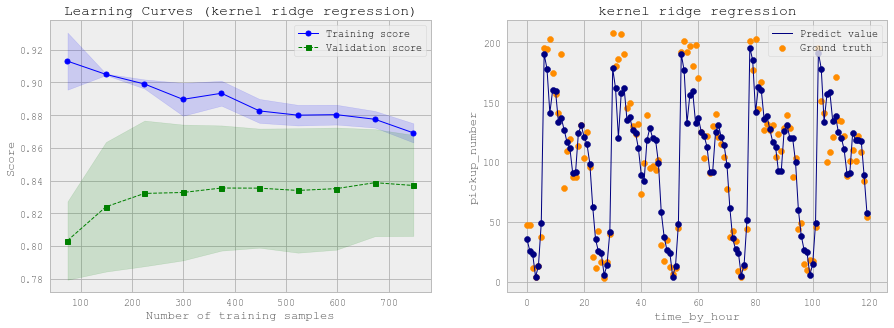

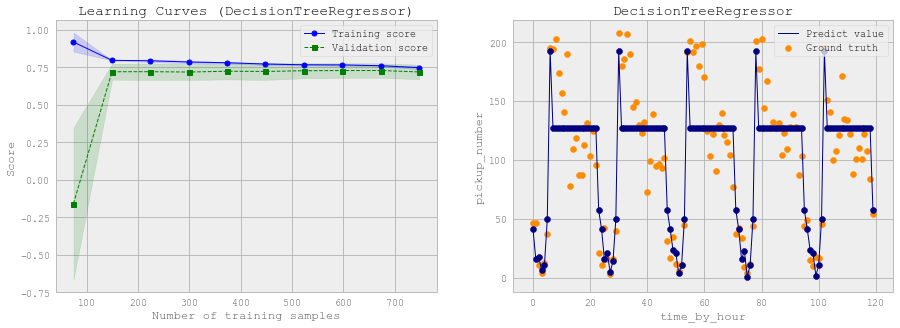

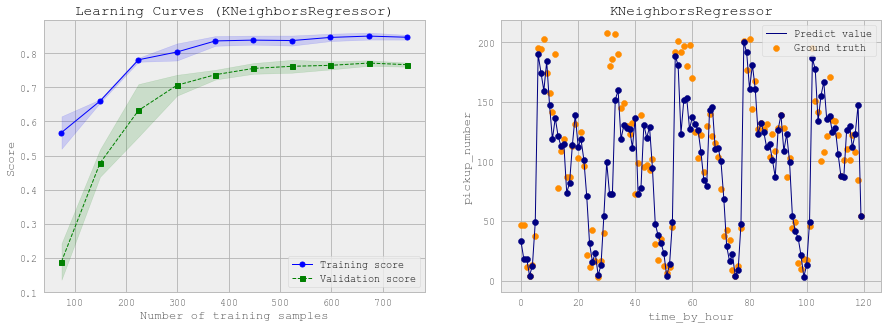

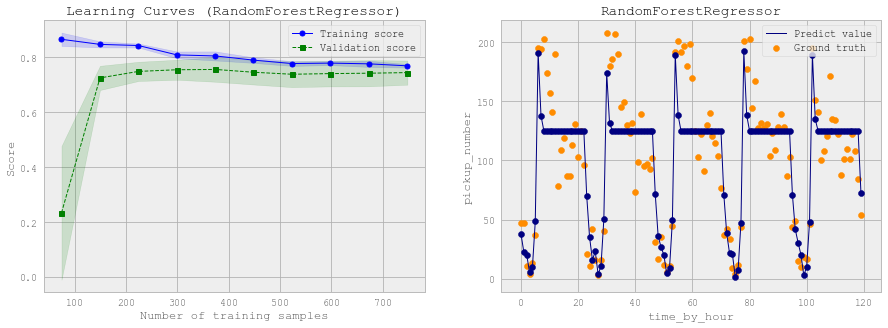

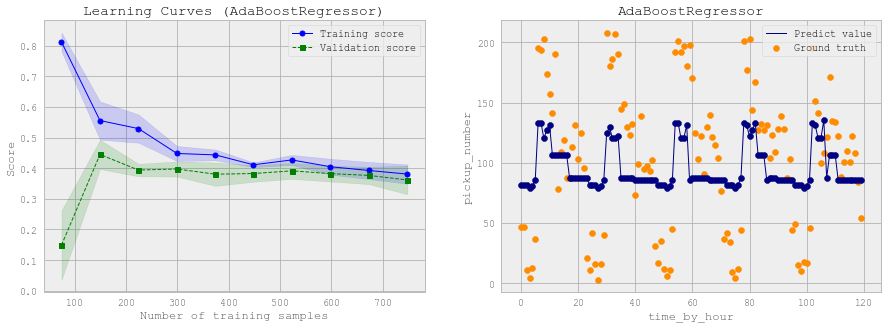

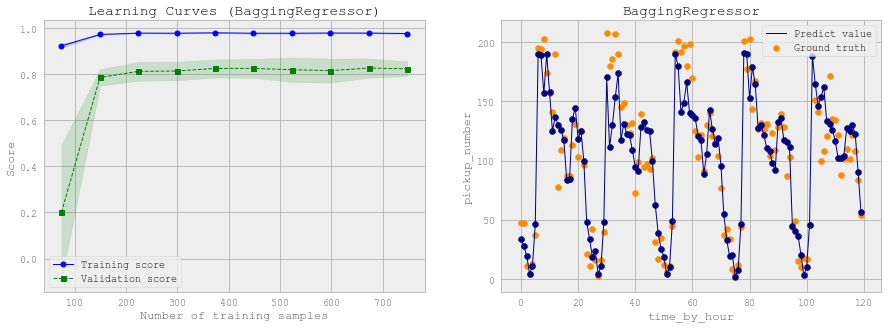

In [50]:
train('-73.994,40.751_weekday.csv')

Best Score: -0.1444
Parameters: {'C': 100, 'gamma': 0.01}
Best Score: -0.2028
Parameters: {'C': 1000}
Best Score: -0.1202
Parameters: {'C': 100, 'degree': 2}
Best Score: -0.085
Parameters: {'min_samples_split': 2, 'loss': 'lad', 'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 1}
Best Score: 0.0096
Parameters: {'alpha': 1.0, 'gamma': 0.01}
Best Score: -0.0402
Parameters: {'max_depth': 2}
Best Score: -0.1001
Parameters: {'n_neighbors': 8}
Best Score: 0.0028
Parameters: {'n_estimators': 150, 'max_depth': 2}
Best Score: -1.3672
Parameters: {'n_estimators': 20}
Best Score: -0.2354
Parameters: {'n_estimators': 150}
bestModel: kernel ridge regression


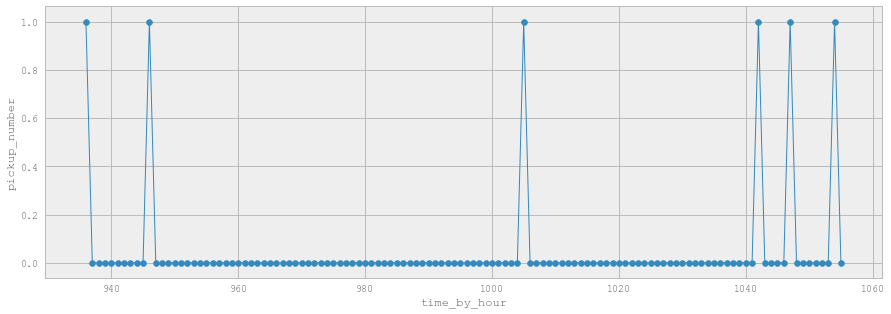

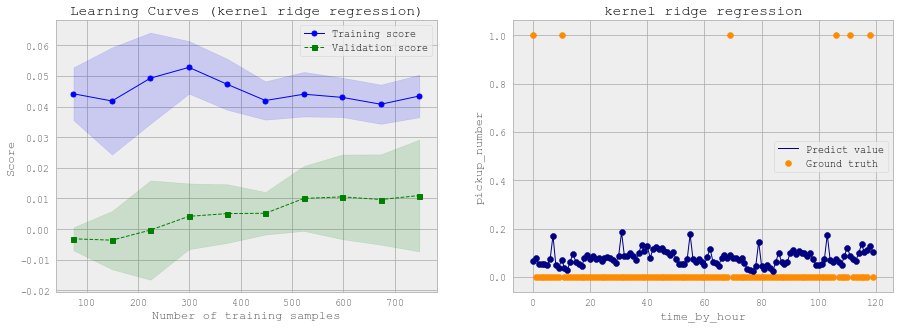

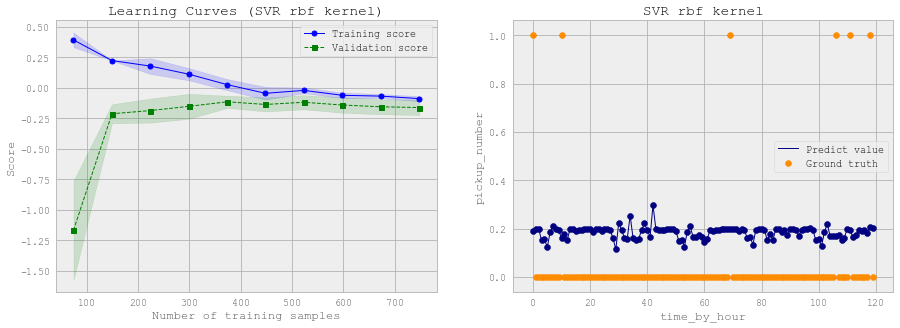

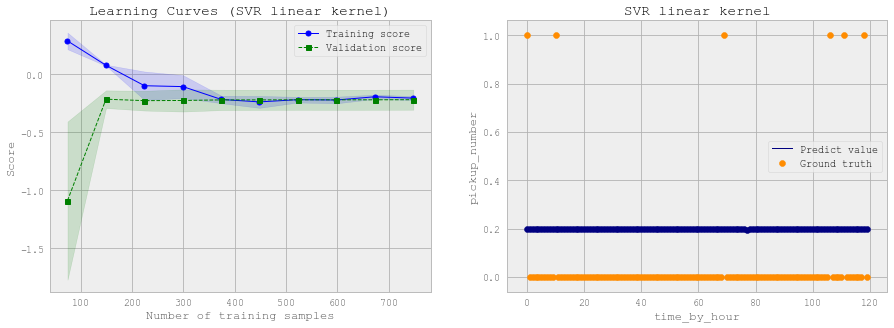

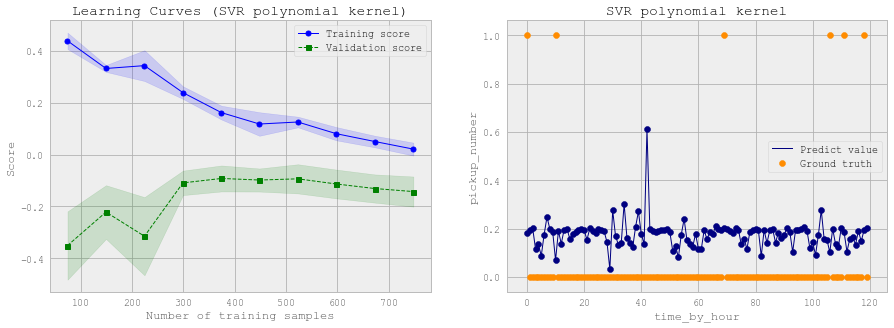

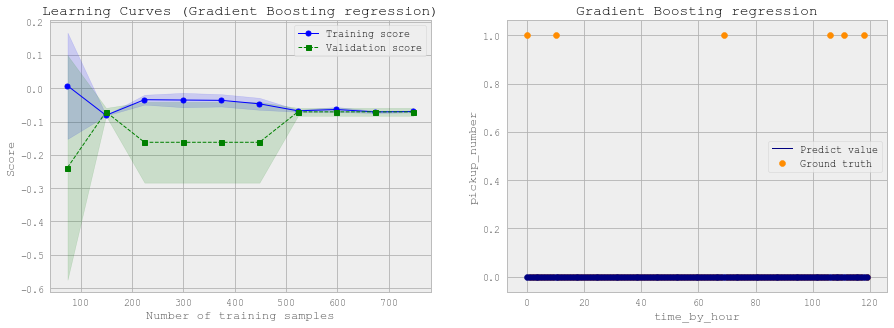

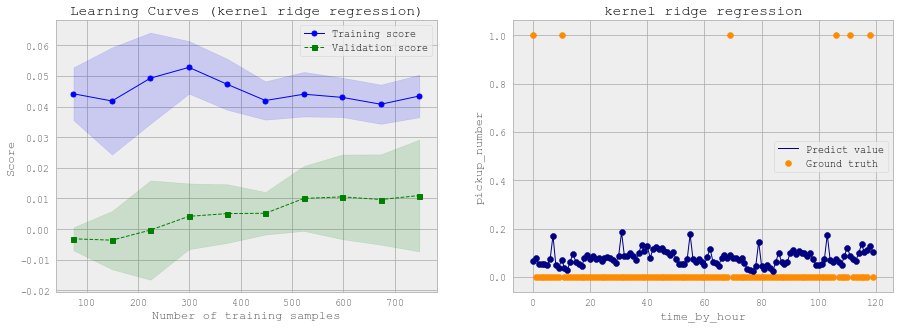

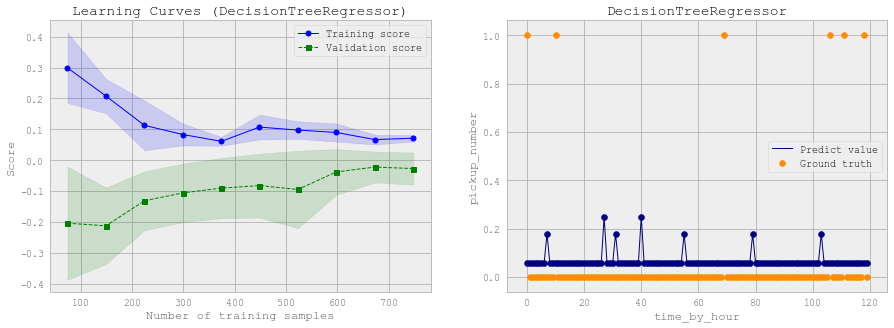

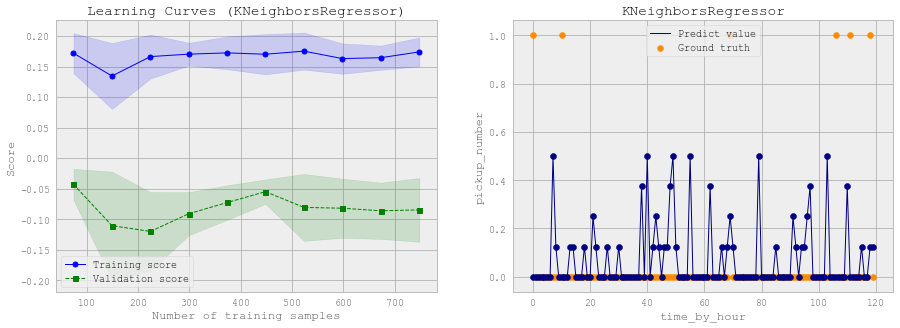

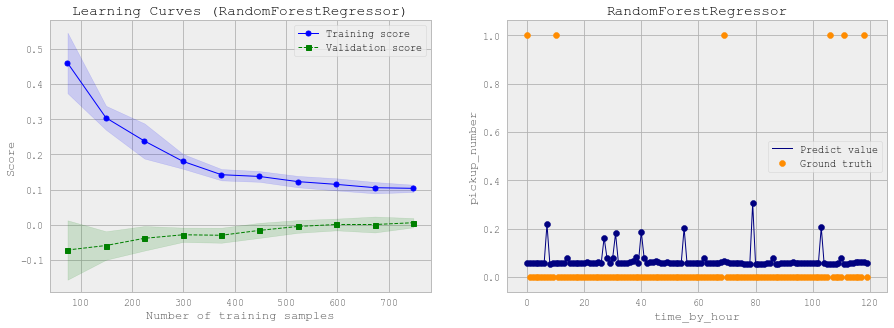

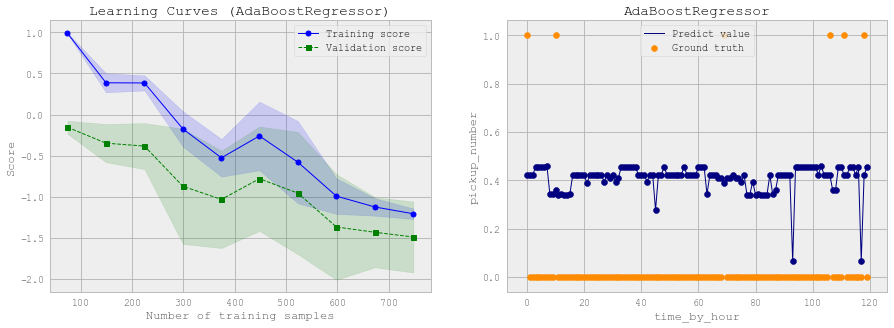

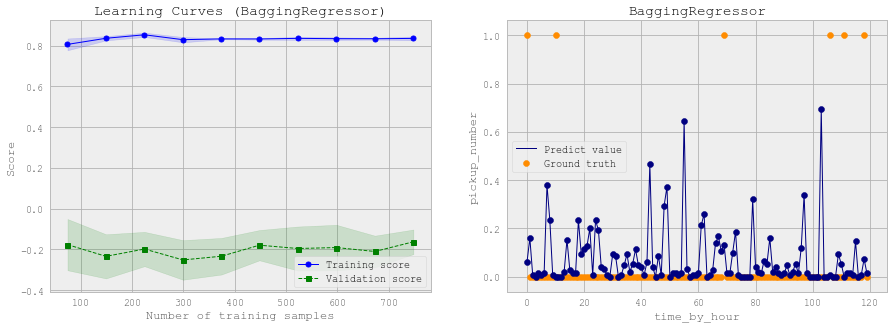

In [51]:
train('-73.925,40.866_weekday.csv')

Best Score: 0.7301
Parameters: {'C': 10, 'gamma': 0.01}
Best Score: 0.7079
Parameters: {'C': 1}
Best Score: 0.7329
Parameters: {'C': 10, 'degree': 1}
Best Score: 0.6746
Parameters: {'min_samples_split': 2, 'loss': 'lad', 'learning_rate': 0.1, 'n_estimators': 900, 'max_depth': 1}
Best Score: 0.7614
Parameters: {'alpha': 0.01, 'gamma': 0.01}
Best Score: 0.7016
Parameters: {'max_depth': 8}
Best Score: 0.7402
Parameters: {'n_neighbors': 2}
Best Score: 0.6502
Parameters: {'n_estimators': 150, 'max_depth': 6}
Best Score: 0.4474
Parameters: {'n_estimators': 20}
Best Score: 0.6092
Parameters: {'n_estimators': 20}
bestModel: kernel ridge regression


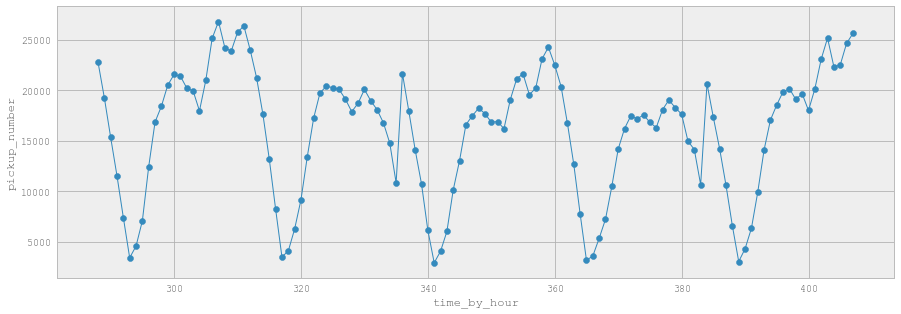

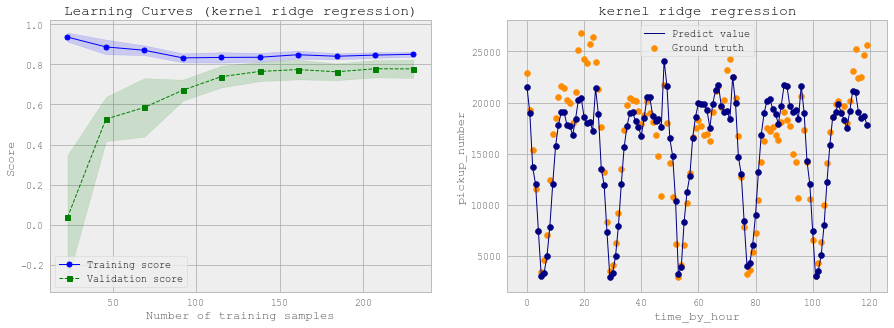

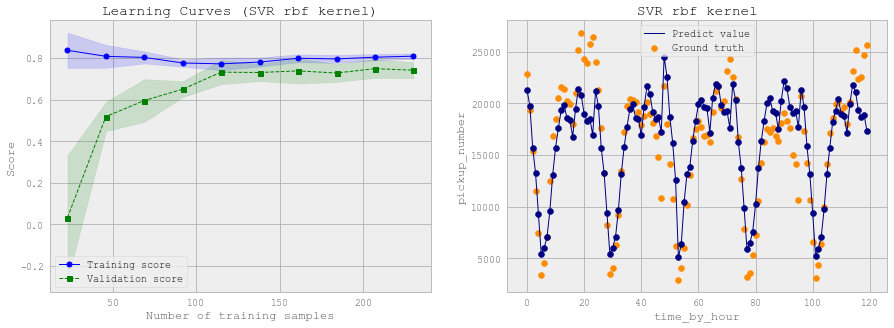

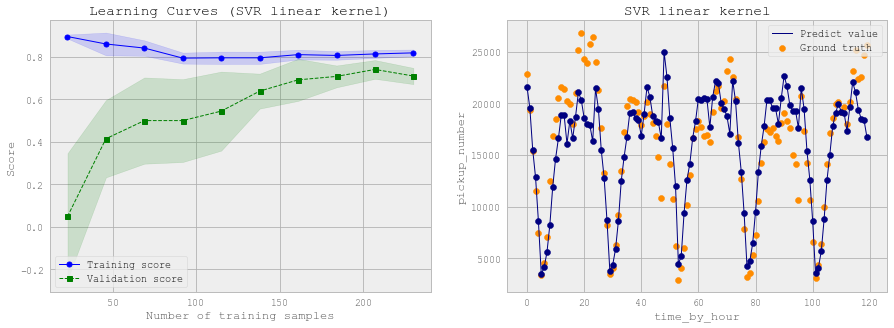

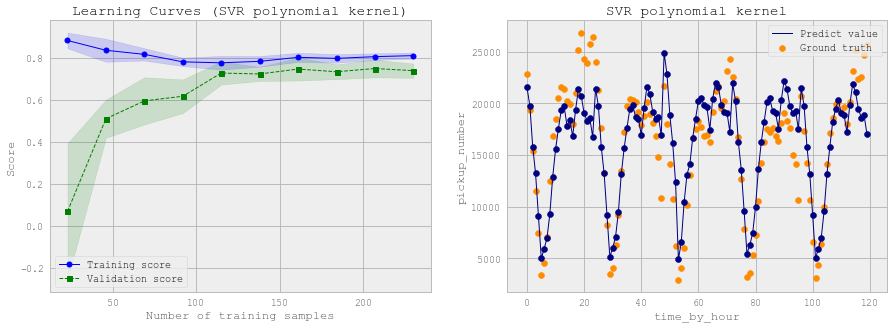

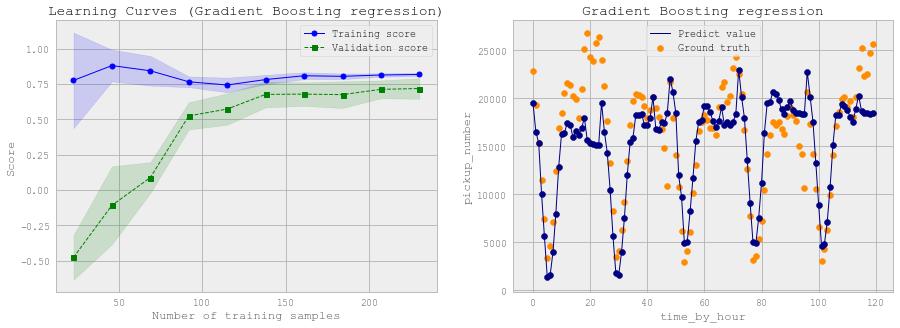

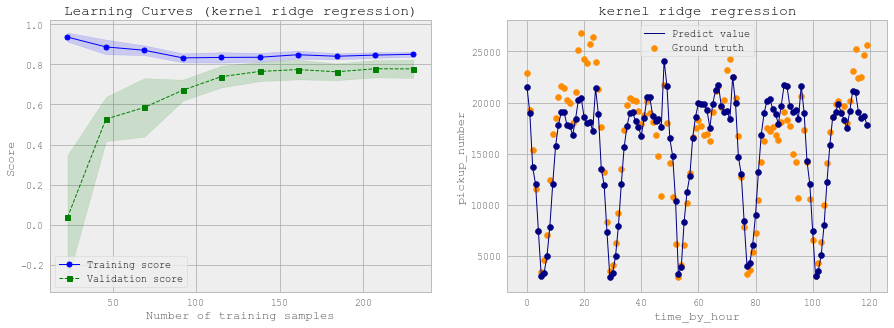

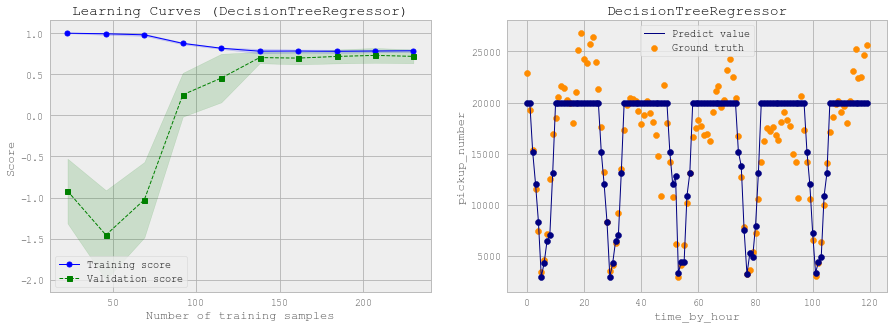

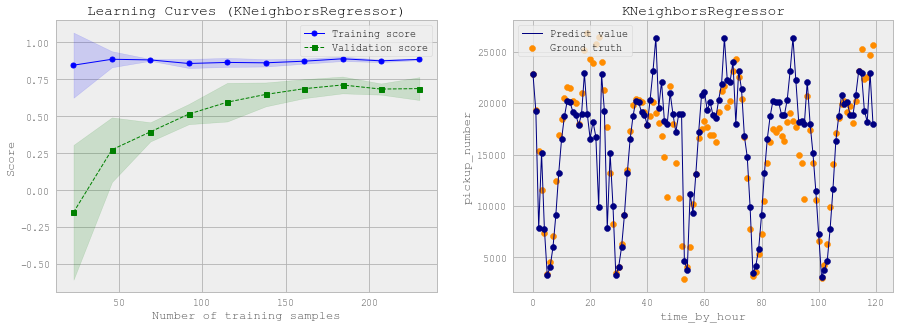

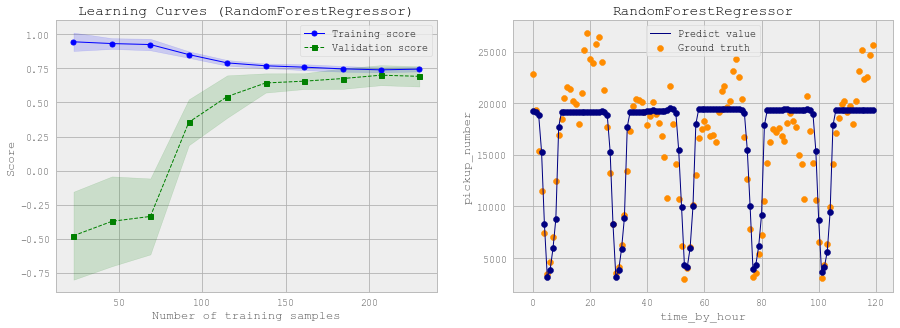

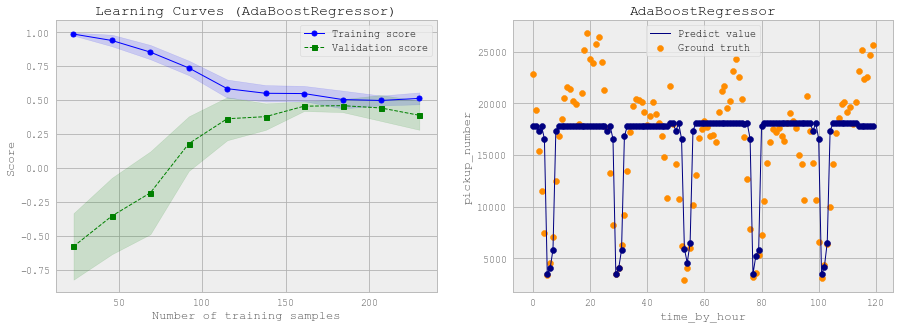

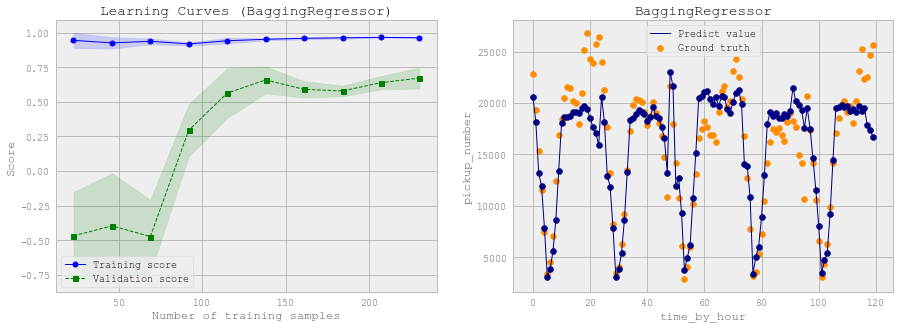

In [30]:
train('pickup_weekend.csv')

In [37]:
# #############################################################################
import os    
import csv
import calendar
import numpy as np

# type(test)=dict
# test = Time	Temp	Weather	Wind	Humidity	Barometer	Visibility
def predict(location):
    
    with open(location+'_coefficient.js','r') as f:
        coe=json.load(f)
        y_max, y_min, x_max, x_min = coe['y_max'], coe['y_min'], np.array(coe['x_max']), np.array(coe['x_min'])

    testData = data - x_min
    testData /= (x_max - x_min)
    testData = pd.DataFrame(testData)
    testData = np.array(testData.join(X))

    model = joblib.load(location + '.pkl')
    y_pred = model.predict(testData)*y_max+y_min
    return np.round(y_pred)
#     return y_pred.astype(np.int)

weather = pd.read_csv('D:/Application/eclipse/workspace/COMSE6998PROJECT/PreProcessWeatherData/weather_processed_again/weather_2016_06.csv')
weather = weather[weather['Time'].str.startswith('07')]
weather['Time'] = weather['Time'].str.slice(3,5).astype(int) # convert Time to int, then to str. Therefore '00' will be '0', which is in the vectorizer
Time = list(weather['Time'])

X = weather[['Weather','Time']].copy()
X['Time'] = X['Time'].astype('str')
X.index = range(0,len(X))
X = [X.loc[index].to_dict() for index in X.index]
vec = joblib.load('models/vec.pkl')
dummyX =vec.transform(X).toarray()
X = pd.DataFrame(dummyX,columns=vec.get_feature_names())

data = np.array(weather[['Temp','Wind','Humidity','Barometer','Visibility']].astype('float'))

isWeekday = calendar.weekday(2016,6,7) <= 4

# # predict pick up number for specific locations
# csvFile = open('result/result_2016_06_03.csv','wb')
# csvWriter = csv.writer(csvFile)
# csvWriter.writerow(['Time', 'longitude', 'latitude', 'count'])

# for f in os.listdir('models/'):
#     if f.endswith("%s_coefficient.js"%('weekday' if isWeekday else 'weekend')) and not f.startswith('pickup'):
#         location = f[:-15]
#         longitude, latitude = location.split(',')
#         latitude = latitude.split('_')[0]
#         try:
#             count = predict('models/'+location)
#             for i in range(len(count)):
#                 csvWriter.writerow([Time[i], longitude, latitude, count[i]])
#         except Exception as e:
#             print e
# csvFile.close()

# predict total pick up number
csvFile = open('result/total_2016_06.csv','ab')
csvWriter = csv.writer(csvFile)
# csvWriter.writerow(['Time', 'count'])

try:
    if isWeekday:
        location = 'pickup_weekday'
    else:
        location = 'pickup_weekend'
    count = predict('models/'+location)
    for i in range(len(count)):
        csvWriter.writerow([Time[i], count[i]])
except Exception as e:
    print e
csvFile.close()